A CNN Mnist Model

In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_05b_early_stopping")' FastaiNotebook_05b_early_stopping

Installing packages:
	.package(path: "/content/FastaiNotebook_05b_early_stopping")
		FastaiNotebook_05b_early_stopping
With SwiftPM flags: []
Working in: /tmp/tmpvbk_3ynp/swift-install
Updating https://github.com/mxcl/Path.swift
Updating https://github.com/saeta/Just
Updating https://github.com/latenitesoft/NotebookExport
Completed resolution in 3.02s
[1/10] Compiling FastaiNotebook_05b_early_stopping 03_minibatch_training.swift
[2/10] Compiling FastaiNotebook_05b_early_stopping 04_callbacks.swift
[3/10] Compiling FastaiNotebook_05b_early_stopping 05_anneal.swift
[4/10] Compiling FastaiNotebook_05b_early_stopping 05b_early_stopping.swift
[5/10] Compiling FastaiNotebook_05b_early_stopping 00_load_data.swift
[6/10] Compiling FastaiNotebook_05b_early_stopping 01_matmul.swift
[7/10] Compiling FastaiNotebook_05b_early_stopping 01a_fastai_layers.swift
[8/10] Compiling FastaiNotebook_05b_early_stopping 02_fully_connected.swift
[9/10] Compiling FastaiNotebook_05b_early_stopping 02a_why_sqrt5.s

In [0]:
//export
import Path
import TensorFlow
import Python

In [0]:
import FastaiNotebook_05b_early_stopping

In [4]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


Load data

In [0]:
let data = mnistDataBunch(flat: false, bs: 512)

In [6]:
let firstBatch = data.train.ds.first(where: { _ in true })!
let batchShape = firstBatch.xb.shape
let batchSize = batchShape.dimensions[0]
let exampleSideSize = batchShape.dimensions[1]
assert(exampleSideSize == batchShape.dimensions[2])
print("Batch size: \(batchSize)")
print("Example side size: \(exampleSideSize)")

let classCount = firstBatch.yb.shape.dimensions[0]
print("Class count: \(classCount)")

Batch size: 512
Example side size: 28
Class count: 512


In [7]:
firstBatch.xb.shape

▿ [512, 28, 28]
  ▿ dimensions : 3 elements
    - 0 : 512
    - 1 : 28
    - 2 : 28


In [0]:
// export
extension Learner {
    public class AddChannel: Delegate {
        public override func batchWillStart(learner: Learner) {
            learner.currentInput = learner.currentInput!.expandingShape(at: -1)
        }
    }
    
    public func makeAddChannel() -> AddChannel { return AddChannel() }
}

In [0]:
//export 
public struct CnnModel: Layer {
    public var convs: [FAConv2D<Float>]
    public var pool = FAGlobalAvgPool2D<Float>()
    public var linear: FADense<Float>
    
    public init(channelIn: Int, nOut: Int, filters: [Int]){
        let allFilters = [channelIn] + filters
        convs = Array(0..<filters.count).map { i in
            return FAConv2D(allFilters[i], allFilters[i+1], ks: 3, stride: 2)
        }
        linear = FADense<Float>(filters.last!, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return linear(pool(convs(input)))
    }
}

In [0]:
let model = CnnModel(channelIn: 1, nOut: 10, filters: [8, 16, 32, 32])

In [11]:
// Test that data goes through the model as expected.
let predictions = model(firstBatch.xb.expandingShape(at: -1))
print(predictions.shape)
print(predictions[0])

[512, 10]
[  0.019917186, -0.0030276626,    0.03614465,   -0.01815737,    0.07419705,    0.21942934,
     0.1248743,   -0.06822176,   -0.17621972,   -0.12775409]


Compare training on CPU and GPU

In [0]:
func optFunc(_ model: CnnModel) -> SGD<CnnModel> { return SGD(for: model, learningRate: 0.4)}
func modelInit() -> CnnModel { return CnnModel(channelIn: 1, nOut: 10, filters: [8, 16, 32, 32]) }
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                      learner.makeAddChannel()])

In [13]:
// This happens on the GPU (if you have one and it's configured correctly).
// I tried this on a GCE 8vCPU 30GB + Tesla P100:
// - time: ~4.3s
// - nvidia-smi shows ~10% GPU-Util while this is running
time { try! learner.fit(1) }

Epoch 0: [0.44488364, 0.8667]
average: 2548.67991 ms,   min: 2548.67991 ms,   max: 2548.67991 ms


Collect Layer Activation Statistics

In [0]:
class ActivationStatsHook {
    var means: [Float] = []
    var stds: [Float] = []    
    func update(_ act: TF) {
        means.append(act.mean().scalarized())
        stds.append (act.std() .scalarized())
    }
}

In [0]:
let learner = Learner(data: data, lossFunc: softmaxCrossEntropy, optFunc: optFunc, modelInit: modelInit)
let recorder = learner.makeDefaultDelegates(metrics: [accuracy])
learner.addDelegates([learner.makeNormalize(mean: mnistStats.mean, std: mnistStats.std),
                      learner.makeAddChannel()])

In [0]:
var statHooks: [ActivationStatsHook] = (0..<learner.model.convs.count).map { i in 
    var stat = ActivationStatsHook()
    learner.model.convs[i].addDelegate(stat.update)
    return stat
}

In [17]:
// This LayerDelegate stuff slows it down to ~6s/epoch.
time { try! learner.fit(2) }

Epoch 0: [0.4338451, 0.8693]
Epoch 1: [0.39911148, 0.89]
average: 4143.966819 ms,   min: 4143.966819 ms,   max: 4143.966819 ms


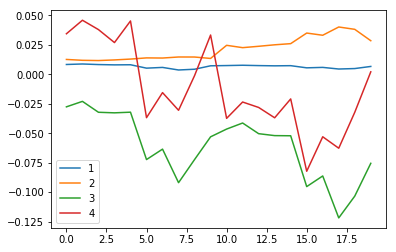

None


In [18]:
for stat in statHooks {
    plt.plot(stat.means)
}
plt.legend(Array(1...statHooks.count))
plt.show()

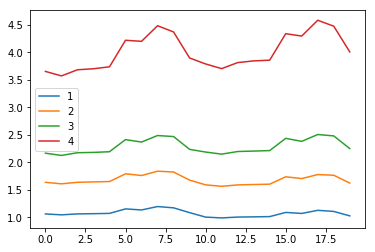

None


In [19]:
for stat in statHooks {
    plt.plot(stat.stds)
}
plt.legend(Array(1...statHooks.count))
plt.show()

Export

In [20]:
import NotebookExport
let exporter = NotebookExport(Path.cwd/"06_cuda.ipynb")
print(exporter.export(usingPrefix: "FastaiNotebook_"))

success
